Fitting a WL mass using `clmm`

_the LSST-DESC CLMM team_

In [1]:
from astropy.cosmology import FlatLambdaCDM
import clmm
import sys
# This notebook must be run from the  
sys.path.append('./support')
import mock_data as mock
from numpy import random
from scipy import optimize as spo

In [2]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import sys
import numpy as np
import cluster_toolkit as ct
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from astropy import constants, cosmology, units
from chainconsumer import ChainConsumer

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())
#Ncm.cfg_set_error_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [3]:
# define a true cosmology
# NB: need to cclify the astropy cosmology for generating the mock data (depends on modeling.py). 
# However, this is the astropy cosmology object that will need to be used on the data side, 
# profileaveraging.py (data side)

mock_cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
# cclify allows access to the cosmo parameter the CCL way, but it is NOT a CCL cosmology object,
# but simply a dictionary
mock_cosmo_ccl = clmm.cclify_astropy_cosmo(mock_cosmo) 

# Make mock data

In [4]:
# define toy cluster parameters

config = {}
config['cosmo'] = mock_cosmo_ccl
config['cluster_id'] = "Awesome_cluster"
config['cluster_m'] = 1.e15
config['cluster_z'] = 0.3
config['src_z'] = 0.8
config['concentration'] = 4
config['ngals'] = 10000
config['Delta'] = 200

In [5]:
# make mock data object

ideal_data = mock.MockData(config=config)

In [6]:
# populate catalog of galaxy cluster

ideal_data.generate() # single source plane, no shape noise, no redshift error

In [7]:
# make a clmm.GalaxyCluster object
# NB: mock data puts galaxy clusters in (0,0)
cluster_ra = 0.0
cluster_dec = 0.0
gc_object = clmm.GalaxyCluster(config['cluster_id'], cluster_ra, cluster_dec, 
                               config['cluster_z'], ideal_data.catalog)

In [8]:
# save the clmm.GalaxyCluster object

gc_object.save('mock_GC.pkl')

# Derive observables

In [9]:
# load a clmm.GalaxyCluster object

cl = clmm.load_cluster('mock_GC.pkl')

ra_l = cl.ra
dec_l = cl.dec
z = cl.z
e1 = cl.galcat['e1']
e2 = cl.galcat['e2']
ra_s = cl.galcat['ra']
dec_s = cl.galcat['dec']

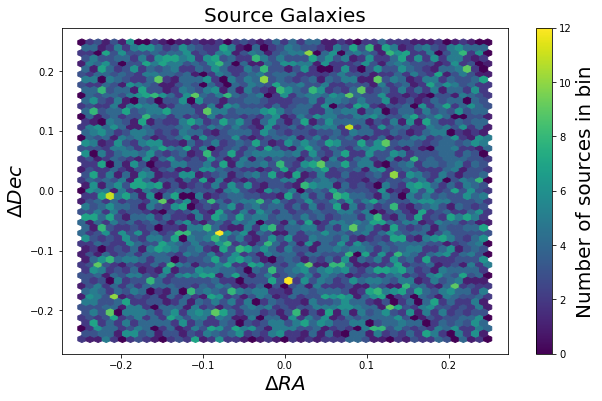

In [10]:
import matplotlib.pyplot as plt
#%matplotlib inline

fsize = 20

fig = plt.figure(figsize=(10,6))
hb = fig.gca().hexbin(ra_s, dec_s, gridsize=50)

cb = fig.colorbar(hb)
cb.set_label('Number of sources in bin', fontsize=fsize)

plt.gca().set_xlabel(r'$\Delta RA$', fontsize=fsize)
plt.gca().set_ylabel(r'$\Delta Dec$', fontsize=fsize)
plt.gca().set_title('Source Galaxies', fontsize=fsize)

plt.show()

### Tangential shear, cross shear for each source galaxy in the cluster

In [11]:
(theta, g_t, g_x) = cl.compute_shear()

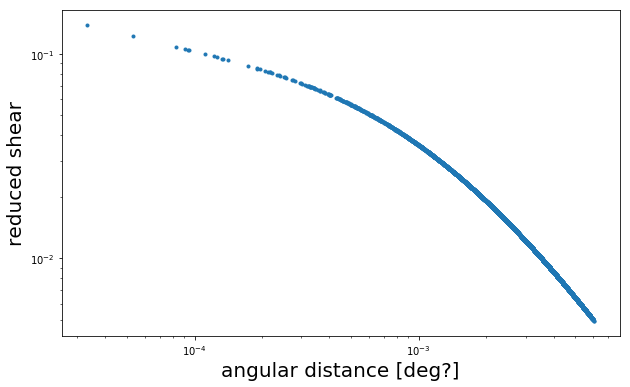

In [12]:
fig = plt.figure(figsize=(10,6))

fig.gca().loglog(theta, g_t, '.')
plt.ylabel("reduced shear", fontsize=fsize)
plt.xlabel("angular distance [deg?]", fontsize=fsize)

### Make the binned profile

Using 2 different binnings to highlight the impact on the reconstructed mass when doing naive fitting (not accounting for the binning in the model estimation)

In [13]:
# define bins
bin_edges1 = clmm.make_bins(0.01, 3.7, 50)
bin_edges2 = clmm.make_bins(0.01, 3.7, 10)

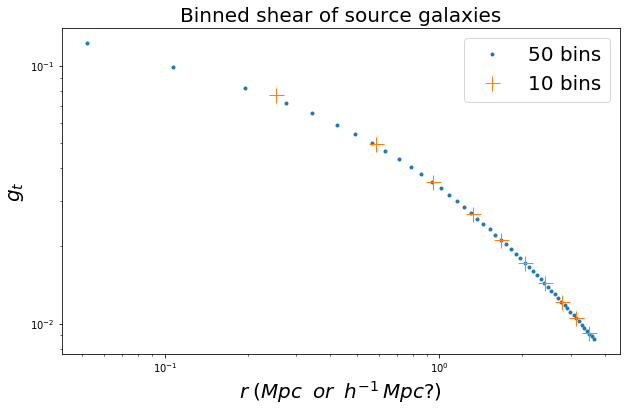

In [14]:
fig = plt.figure(figsize=(10,6))

res1 = cl.make_shear_profile("Mpc", cosmo=mock_cosmo, cosmo_object_type='astropy', 
                             bins=bin_edges1)
res2 = cl.make_shear_profile("Mpc", cosmo=mock_cosmo, cosmo_object_type='astropy', 
                             bins=bin_edges2)

fig.gca().loglog(res1['radius'], res1['gt'], '.', label='50 bins')
fig.gca().loglog(res2['radius'], res2['gt'], '+', markersize=15, label='10 bins')
plt.legend(fontsize=fsize)
gt_profile1 = res1['gt']
r1 = res1['radius']

gt_profile2 = res2['gt']
r2 = res2['radius']

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;(Mpc\;\;or\;\;h^{-1}\,Mpc?)$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)


In [15]:
# And now the galaxy cluster as a profile attribute
cl.profile

radius,gt,gt_err,gx,gx_err
float64,float64,float64,float64,float64
0.2536857737742042,0.07735597426276188,0.0018927186982090178,1.0119220276531375e-18,1.0119220276531375e-18
0.586677846214382,0.04970896850080702,0.000392453316874585,9.281427688701667e-20,9.281427688701667e-20
0.948330944483286,0.03535102301405847,0.00016112829914714468,-5.357042934250877e-19,-5.357042934250877e-19
1.3194880479922175,0.026639985859785244,8.971184929380284e-05,-3.451424974352459e-19,-3.451424974352459e-19
1.6756012143831711,0.021171316466654617,5.463686939469177e-05,7.090542009498413e-20,7.090542009498413e-20
2.0448787719829244,0.017212745182453134,3.478703012647397e-05,2.41257455680707e-19,2.41257455680707e-19
2.412516284339319,0.014341375341247508,2.4325809250504615e-05,7.396584973347062e-20,7.396584973347062e-20
2.7834009948034044,0.012157025786918886,1.6885637804635077e-05,1.1150402457739254e-19,1.1150402457739254e-19
3.1488431546512383,0.010488183081888132,1.281124824987454e-05,-3.969781121652608e-20,-3.969781121652608e-20


# Construct model

Simply estimating the model at the bin location. In that case, the mass reconstruction is dependent on the binning. Future developement would be to take the average of the model inside the bin instead, which should solve this issue for this set of ideal data.

In [16]:
# select density profile parametrization and parameter values
def nfw_to_shear_profile1(logm):
    m = 10.**logm
    gt_model = clmm.predict_reduced_tangential_shear(r1, m, config['concentration'], config['cluster_z'], 
                                                    config['src_z'], config['cosmo'], 
                                        Delta=200, halo_profile_parameterization='nfw')
    return sum((gt_model - gt_profile1) **2)

def nfw_to_shear_profile2(logm):
    m = 10.**logm
    gt_model = clmm.predict_reduced_tangential_shear(r2, m, config['concentration'], config['cluster_z'], 
                                                    config['src_z'], config['cosmo'], 
                                        Delta=200, halo_profile_parameterization='nfw')
    return sum((gt_model - gt_profile2) **2)

# Fit for mass

In [17]:
# optimize to find the best-fit mass

logm_0 = random.uniform(13., 17., 1)[0]
logm_est1 = spo.minimize(nfw_to_shear_profile1, logm_0).x
logm_est2 = spo.minimize(nfw_to_shear_profile2, logm_0).x
m_est1 = 10.**logm_est1
m_est2 = 10.**logm_est2

In [18]:
m_est1, m_est2

(array([1.01120699e+15]), array([1.03821664e+15]))

In [19]:
import numpy as np
rr = np.logspace(-2,np.log10(5),100)
gt_model1 = clmm.predict_reduced_tangential_shear(rr, m_est1, config['concentration'], config['cluster_z'], 
                                                    config['src_z'], config['cosmo'], 
                                        Delta=200, halo_profile_parameterization='nfw')

gt_model2 = clmm.predict_reduced_tangential_shear(rr, m_est2, config['concentration'], config['cluster_z'], 
                                                    config['src_z'], config['cosmo'], 
                                        Delta=200, halo_profile_parameterization='nfw')

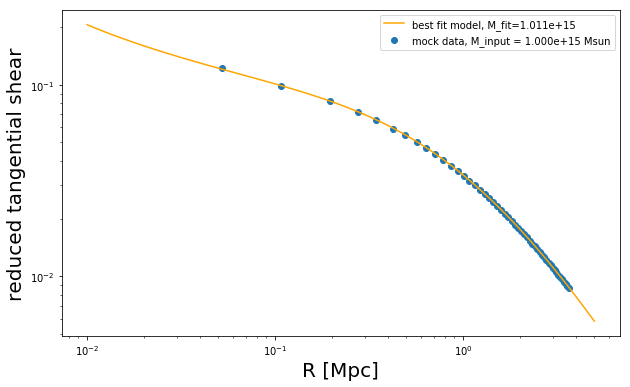

In [20]:
fig = plt.figure(figsize=(10,6))

fig.gca().scatter(r1, gt_profile1, label='mock data, M_input = %.3e Msun'%config['cluster_m'])
fig.gca().plot(rr, gt_model1, label = 'best fit model, M_fit=%.3e'%m_est1, color='orange')
plt.semilogx()
plt.semilogy()

plt.legend()
plt.xlabel('R [Mpc]', fontsize=fsize)
plt.ylabel('reduced tangential shear', fontsize=fsize)

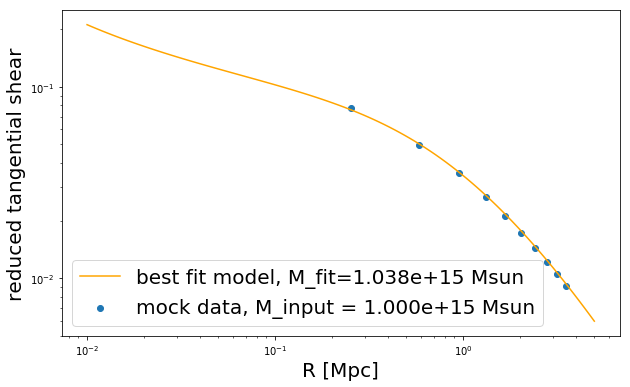

In [21]:
fig = plt.figure(figsize=(10,6))

fig.gca().scatter(r2, gt_profile2, label='mock data, M_input = %.3e Msun'%config['cluster_m'])
fig.gca().plot(rr, gt_model2, label = 'best fit model, M_fit=%.3e Msun'%m_est2, color='orange')
plt.semilogx()
plt.semilogy()

plt.legend(fontsize=fsize)
plt.xlabel('R [Mpc]', fontsize=fsize)
plt.ylabel('reduced tangential shear', fontsize=fsize)

In [22]:
mb = Ncm.ModelBuilder.new (Ncm.Model, "NcClusterModel", 
                           "A simple model to describe clusters")
mb.add_sparam (r'RA',     'RA',     -180.0, 180.0, 1.0e-2, 0.0, 0.0,  Ncm.ParamType.FREE)
mb.add_sparam (r'DEC',    'DEC',     -90.0,  90.0, 1.0e-2, 0.0, 0.0,  Ncm.ParamType.FREE)

mb.add_sparam (r'\ln(M)', 'ln_mass', 12.0 * math.log(10), 17.0 * math.log(10), 1.0, 0.0, 12.0 * math.log(10),  Ncm.ParamType.FREE)
mb.add_sparam (r'c',      'c',       3.0, 10.0, 0.1, 0.0, 5.0,  Ncm.ParamType.FREE)

GNcClusterModel = mb.create ()
GObject.new (GNcClusterModel)
NcClusterModel = GNcClusterModel.pytype
GObject.type_register (NcClusterModel)


__gi__.NcClusterModel

In [23]:
class NcDataClusterShear (Ncm.DataGaussDiag):
    
    bins  = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)
    Delta = GObject.Property (type = float, flags = GObject.PARAM_READWRITE)
    
    def __init__ (self, **kwargs):
        Ncm.DataGaussDiag.__init__ (self, **kwargs)
        self.cl    = cl
        if self.props.bins:
            self.set_size (self.props.bins.len () - 1)
            self.props.sigma.set_all (0.005)
            self.set_init (True)
    
    def do_get_length (self):
        return self.props.bins.len () - 1

    def do_begin (self):
        pass

    def do_prepare (self, mset):
        mid  = mset.get_id_by_ns ("NcClusterModel")
        ncmm = mset.peek (mid)

        self.cl.ra  = ncmm.props.RA
        self.cl.dec = ncmm.props.DEC
        
        self.cl.compute_shear()
        
        self.cl.make_shear_profile("Mpc", cosmo=mock_cosmo, cosmo_object_type='astropy', bins=self.props.bins.dup_array ())
        
        self.props.mean.set_array (self.cl.profile['gt'])
        

    def do_mean_func (self, mset, v):
        mid  = mset.get_id_by_ns ("NcClusterModel")
        ncmm = mset.peek (mid)

        r_a  = self.cl.profile['radius']
        
        gt_model = clmm.predict_reduced_tangential_shear(r_a, math.exp (ncmm.props.ln_mass), ncmm.props.c, self.cl.z, 
                                                         np.mean (cl.galcat['z']), mock_cosmo, Delta=int(self.props.Delta), halo_profile_parameterization='nfw')
        
        v.set_array (gt_model)
        pass

GObject.type_register (NcDataClusterShear)
data = NcDataClusterShear (Delta = 200.0, bins = Ncm.Vector.new_array (bin_edges1))

In [24]:
ncmm = NcClusterModel ()

mset = Ncm.MSet.empty_new ()
mset.set (ncmm)

ncmm.props.c           = 4.0
ncmm.props.c_fit       = True
ncmm.props.RA_fit      = False
ncmm.props.DEC_fit     = False
ncmm.props.ln_mass_fit = True

mset.prepare_fparam_map ()

dset = Ncm.Dataset.new ()
dset.append_data (data)
lh = Ncm.Likelihood.new (dset)

fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

fit.run (Ncm.FitRunMsgs.SIMPLE)
fit.log_info ()

fit.fisher ()
fit.log_covar ()


#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#..................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:02.4783380
#  iteration            [000096]
#  function evaluations [000098]
#  gradient evaluations [000000]
#  degrees of freedom   [000048]
#  m2lnL     =    0.137764172631742 (    0.13776417 )
#  Fit parameters:
#     34.528312232792      4.05440445642047    
#----------------------------------------------------------------------------------
# Data used:
#   - NcContext+NcDataClusterShear
#----------------------------------------------------------------------------------
# Model[15000]:
#   - NcClusterModel : A simple model to describe clusters
#----------------------------------------------------------------------------------
# Mode

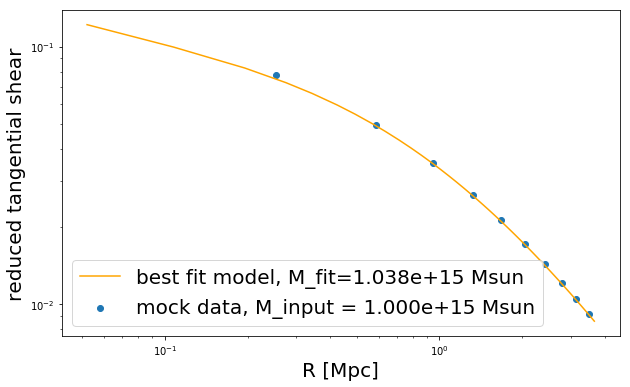

In [25]:
fig = plt.figure(figsize=(10,6))

mu = data.v.dup ()
data.mean_vector (mset, mu)

fig.gca().scatter(r2, gt_profile2, label='mock data, M_input = %.3e Msun'%config['cluster_m'])
fig.gca().plot(cl.profile['radius'], mu.dup_array (), label = 'best fit model, M_fit=%.3e Msun'%m_est2, color='orange')
plt.semilogx()
plt.semilogy()

plt.legend(fontsize=fsize)
plt.xlabel('R [Mpc]', fontsize=fsize)
plt.ylabel('reduced tangential shear', fontsize=fsize)

In [26]:

cov = fit.fstate.covar
cov.scale (2.0)

init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset)
init_sampler.set_cov (cov);
init_sampler.set_prior_from_mset ()
#init_sampler.set_cov_from_rescale (1.0)

use_APS  = True
nwalkers = 100
walker   = None

if use_APS:
    walker = Ncm.FitESMCMCWalkerAPS.new (nwalkers, mset.fparams_len ())
else:
    walker = Ncm.FitESMCMCWalkerStretch.new (nwalkers, mset.fparams_len ())
    walker.set_box_mset (mset)

esmcmc  = Ncm.FitESMCMC.new (fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE)

esmcmc.props.log_time_interval = 60.0 * 10.0
esmcmc.props.intermediary_log = 4

esmcmc.set_auto_trim (True)
esmcmc.set_auto_trim_div (100)
esmcmc.set_auto_trim_type (Ncm.MSetCatalogTrimType.CK)
esmcmc.set_max_runs_time (2.0 * 60.0)

esmcmc.start_run ()
esmcmc.run_lre (200, 1.0e-1)
esmcmc.end_run ()



#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensamble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0100.
#   Number of threads: 0000.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 3137420770.
# NcmMSetCatalog: Current mean:   3.7174       34.529       4.0546     
# NcmMSetCatalog: Current msd:    0.361        0.0090694    0.020277   
# NcmMSetCatalog: Current sd:     3.61         0.090694     0.20277    
# NcmMSetCatalog: Current var:    13.032       0.0082255    0.041115   
# NcmMSetCatalog: Current tau:    1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10                 
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `1':
# NcmMSetCatalog: Constant break po

/home/sandro/.local/lib/python3.7/site-packages/chainconsumer/analysis.py:316: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, edges = np.histogram(data, bins=bins, normed=True, weights=chain.weights)


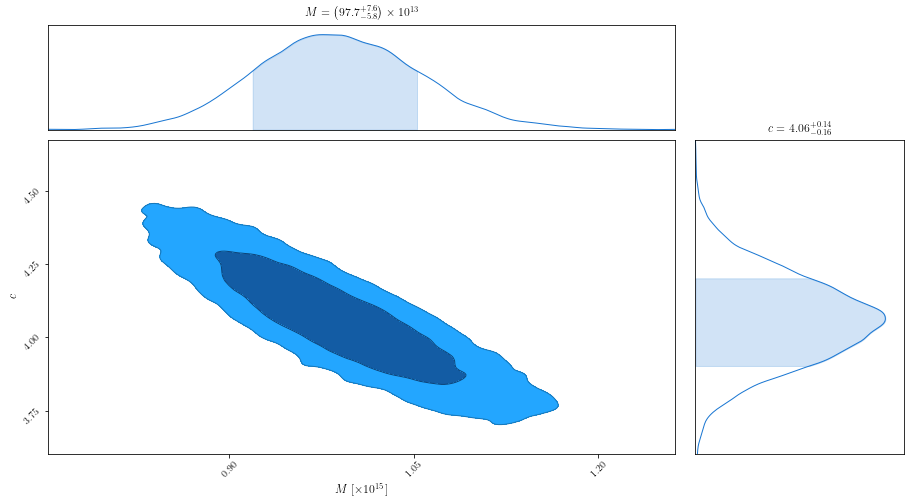

In [28]:
c = ChainConsumer ()

mcat = esmcmc.peek_catalog ()
nchains = mcat.nchains ()

rows      = np.array ([mcat.peek_row (i).dup_array () for i in range (mcat.len ())])
rows[:,1] = np.exp (rows[:,1])
params    = ["$" + mcat.col_symb (i) + "$" for i in range (mcat.ncols ())]
params[1] = r"$M$"

c.add_chain (rows[:,1:], walkers = nchains, parameters = params[1:], posterior = -rows[:,0]/2, name = "My catalog")

fig = c.plotter.plot (figsize=(14,7))
